<a href="https://colab.research.google.com/github/vincent-doan/convolutional-neural-net/blob/main/convolutional_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRELIMINARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 6.3 MB/s eta 0:00:00


In [3]:
import shutil
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchmetrics
from torch import nn, optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn import functional as F, init as init
from torchvision.datasets import ImageFolder
from torchvision import transforms

# DATASET

## Data loading

In [4]:
train_path = '/content/drive/MyDrive/data/mnist-dataset-jpg/mnist-train/'
test_path = '/content/drive/MyDrive/data/mnist-dataset-jpg/mnist-test/'

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28), antialias=True)
])

In [9]:
# Define paths for local storage
local_train_path = '/content/mnist-train/'
local_test_path = '/content/mnist-test/'

# Delete existing directories if they exist
if os.path.exists(local_train_path):
    shutil.rmtree(local_train_path)

if os.path.exists(local_test_path):
    shutil.rmtree(local_test_path)

# Copy data from Google Drive to local storage (only need to run this once)
shutil.copytree(train_path, local_train_path)
shutil.copytree(test_path, local_test_path)

# Use local paths for data loading
train_dataset = ImageFolder(local_train_path, transform=train_transforms)
test_dataset = ImageFolder(local_test_path, transform=train_transforms)

In [10]:
BATCH_SIZE = 128
SHUFFLE = True

train_dataloader = DataLoader(
    train_dataset,
    shuffle=SHUFFLE,
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=SHUFFLE,
    batch_size=BATCH_SIZE
)

## Data overview

TRAINING SET


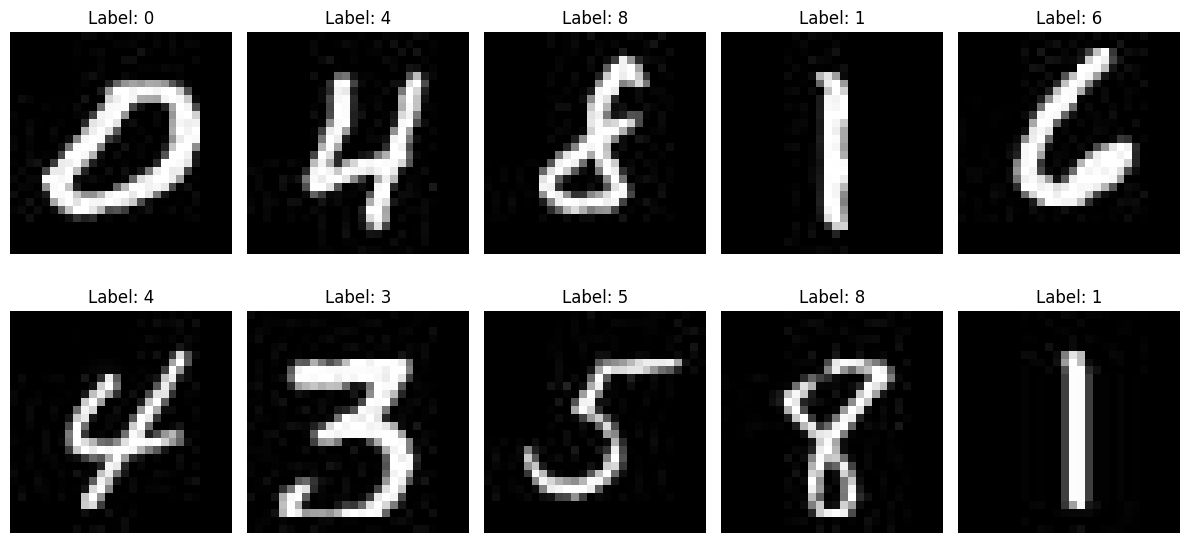

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
images, labels = next(iter(train_dataloader))
selected_images = images[:10]
selected_labels = labels[:10]

print("TRAINING SET")
for i in range(10):
    image = selected_images[i].squeeze().permute(1, 2, 0)
    label = selected_labels[i].item()

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

TEST SET


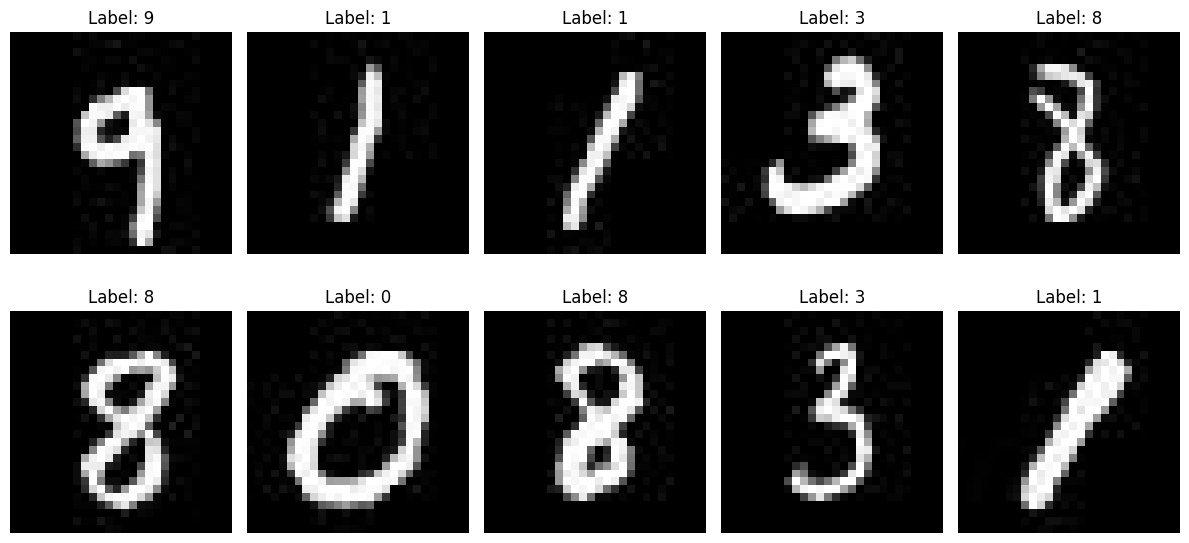

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
images, labels = next(iter(test_dataloader))
selected_images = images[:10]
selected_labels = labels[:10]

print("TEST SET")
for i in range(10):
    image = selected_images[i].squeeze().permute(1, 2, 0)
    label = selected_labels[i].item()

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# NETWORK

## Architecture

In [13]:
INPUT_SIZE = 784
NUM_CLASSES = 10

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, NUM_CLASSES),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Training & Evaluation

In [14]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

acc = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES)

Epoch 1    : Training loss =  1.5244  - Training accuracy =  0.9453  - Testing loss =  1.4838  - Testing accuracy =  0.9502 
Epoch 2    : Training loss =  1.4828  - Training accuracy =  0.9642  - Testing loss =  1.4808  - Testing accuracy =  0.9654 
Epoch 3    : Training loss =  1.4787  - Training accuracy =  0.9709  - Testing loss =  1.4782  - Testing accuracy =  0.9716 
Epoch 4    : Training loss =  1.4769  - Training accuracy =  0.9746  - Testing loss =  1.4757  - Testing accuracy =  0.9750 
Epoch 5    : Training loss =  1.4749  - Training accuracy =  0.9771  - Testing loss =  1.4774  - Testing accuracy =  0.9773 
Epoch 6    : Training loss =  1.4742  - Training accuracy =  0.9788  - Testing loss =  1.4779  - Testing accuracy =  0.9789 
Epoch 7    : Training loss =  1.4729  - Training accuracy =  0.9802  - Testing loss =  1.4788  - Testing accuracy =  0.9802 
Epoch 8    : Training loss =  1.4717  - Training accuracy =  0.9813  - Testing loss =  1.4771  - Testing accuracy =  0.9813 


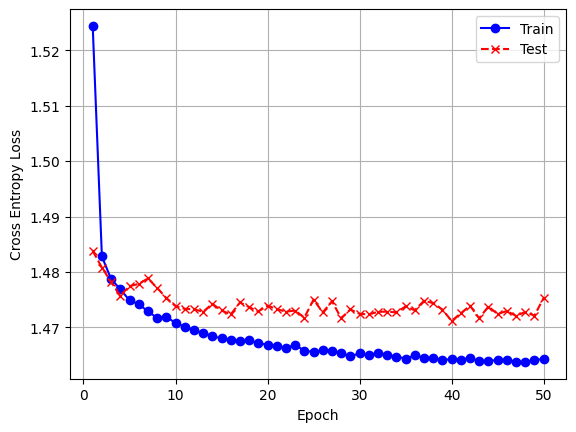

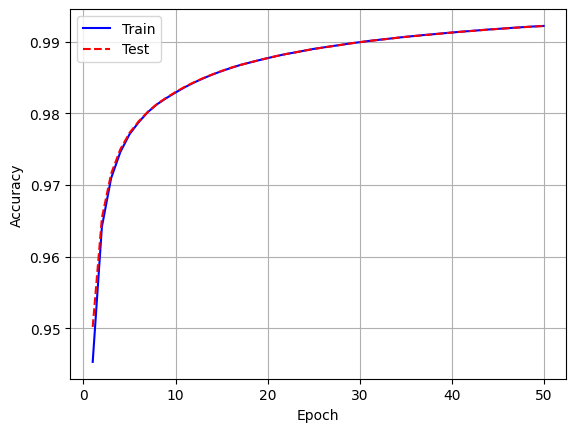

In [15]:
SEED = 1989
torch.manual_seed(SEED)

NUM_EPOCHS = 50

train_epoch_losses = []
test_epoch_losses = []
train_epoch_accs = []
test_epoch_accs = []

for epoch in range(NUM_EPOCHS):

  # TRAINING
  net.train()
  training_loss = 0.0
  for images, labels in train_dataloader:
    # One-hot target
    labels = F.one_hot(labels.to(torch.int64), num_classes=NUM_CLASSES).float()

    # Set gradients to zero
    optimizer.zero_grad()
    # Forward pass
    preds = net(images)
    # Calculate accuracy
    train_acc = acc(preds.argmax(dim=-1), labels.argmax(dim=-1))
    # Compute loss
    loss = criterion(preds, labels)
    training_loss += loss.item()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()

  train_epoch_loss = training_loss / len(train_dataloader)
  train_epoch_losses.append(train_epoch_loss)

  train_epoch_acc = acc.compute()
  train_epoch_accs.append(train_epoch_acc)

  # TESTING
  net.eval()
  validation_loss = 0.0
  with torch.no_grad():
    for images, labels in test_dataloader:
      # One-hot target
      labels = F.one_hot(labels.to(torch.int64), num_classes=NUM_CLASSES).float()

      # Forward pass
      preds = net(images)
      # Calculate accuracy
      test_acc = acc(preds.argmax(dim=-1), labels.argmax(dim=-1))
      # Compute loss
      loss = criterion(preds, labels)
      validation_loss += loss.item()

  test_epoch_loss = validation_loss / len(test_dataloader)
  test_epoch_losses.append(test_epoch_loss)

  test_epoch_acc = acc.compute()
  test_epoch_accs.append(test_epoch_acc)

  print("Epoch {0:<5}: Training loss = {1:^8.4f} - Training accuracy = {2:^8.4f} - Testing loss = {3:^8.4f} - Testing accuracy = {4:^8.4f}".format(epoch+1, train_epoch_loss, train_epoch_acc, test_epoch_loss, test_epoch_acc))

x_values = range(1, NUM_EPOCHS+1)

plt.plot(x_values, train_epoch_losses, marker='o', linestyle='-', color='b', label='Train')
plt.plot(x_values, test_epoch_losses, marker='x', linestyle='--', color='r', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(x_values, train_epoch_accs, linestyle='-', color='b', label='Train')
plt.plot(x_values, test_epoch_accs, linestyle='--', color='r', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Total misclassified examples: 144


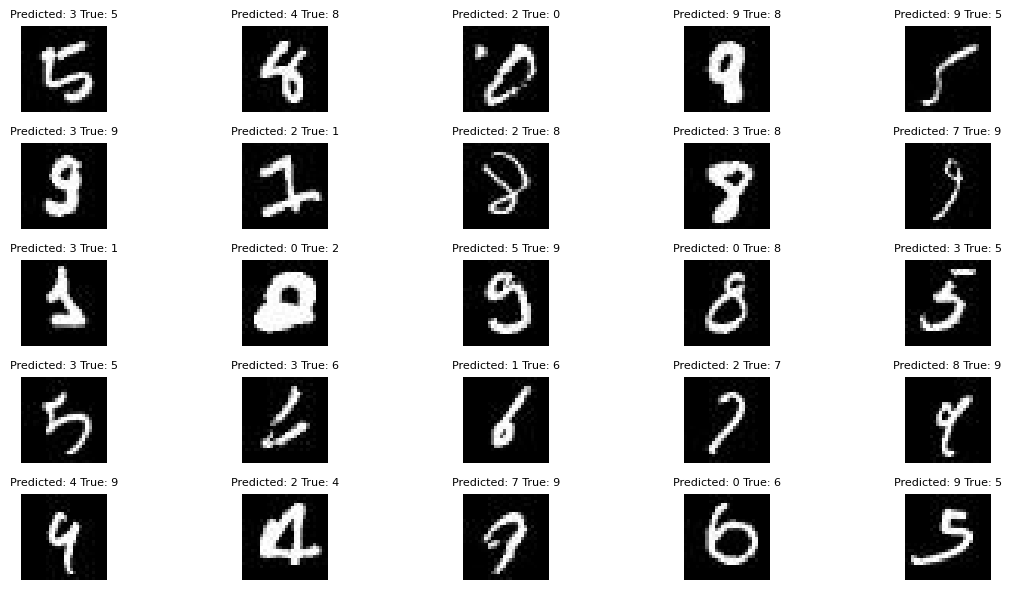

In [16]:
misclassified_examples = []
net.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
      preds = net(images)
      predicted_labels = preds.argmax(dim=-1)
      incorrect_indices = torch.where(predicted_labels != labels)[0]

      for idx in incorrect_indices:
          image = images[idx]
          predicted_label = predicted_labels[idx]
          true_label = int(labels[idx])
          misclassified_examples.append((image, predicted_label, true_label))

print("Total misclassified examples:", len(misclassified_examples))

fig, axes = plt.subplots(5, 5, figsize=(12, 6))

for i, (image, predicted_label, true_label) in enumerate(misclassified_examples[:25]):
    image = image.squeeze().permute(1, 2, 0)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Predicted: {predicted_label} True: {true_label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Total classified examples: 9856


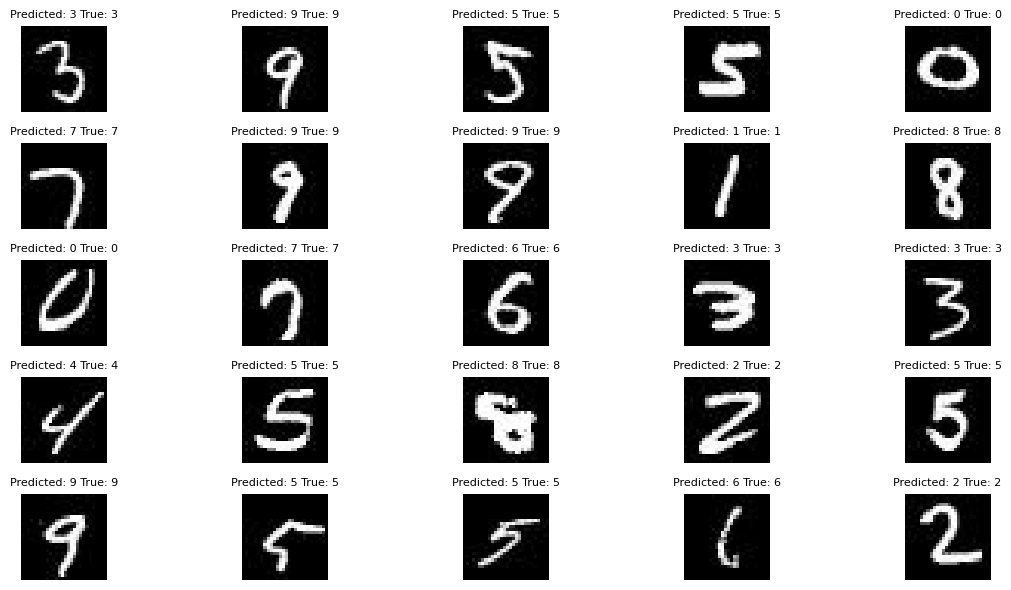

In [17]:
classified_examples = []
net.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
      preds = net(images)
      predicted_labels = preds.argmax(dim=-1)
      correct_indices = torch.where(predicted_labels == labels)[0]

      for idx in correct_indices:
          image = images[idx]
          predicted_label = predicted_labels[idx]
          true_label = int(labels[idx])
          classified_examples.append((image, predicted_label, true_label))

print("Total classified examples:", len(classified_examples))

fig, axes = plt.subplots(5, 5, figsize=(12, 6))

for i, (image, predicted_label, true_label) in enumerate(classified_examples[:25]):
    image = image.squeeze().permute(1, 2, 0)

    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Predicted: {predicted_label} True: {true_label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [18]:
torch.save(net, 'net.pth')